# Import Libraries

In [1]:
import openvino as ov
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load Models

In [2]:
core = ov.Core()

model_face = core.read_model(model='models/face-detection-adas-0001.xml')
compiled_model_face = core.compile_model(model = model_face, device_name="CPU")

input_layer_face = compiled_model_face.input(0)
output_layer_face = compiled_model_face.output(0)

print("Input shape:", input_layer_face.shape)
print("Output shape:", output_layer_face.shape)

model_emo = core.read_model(model='models/emotions-recognition-retail-0003.xml')
compiled_model_emo = core.compile_model(model = model_emo, device_name="CPU")

input_layer_emo = compiled_model_emo.input(0)
output_layer_emo = compiled_model_emo.output(0)

print("Input shape:", input_layer_emo.shape)
print("Output shape:", output_layer_emo.shape)

Input shape: [1,3,384,672]
Output shape: [1,1,200,7]
Input shape: [1,3,64,64]
Output shape: [1,5,1,1]


# Funcion

In [3]:
import numpy as np

def preprocess(image, input_layer):
    N, input_channels, input_height, input_width = input_layer.shape

    resized_image = cv2.resize(image, (input_width, input_height))
    transposed_image = resized_image.transpose(2, 0, 1)
    input_image = np. expand_dims(transposed_image, 0)

    return input_image

In [4]:
def find_faceboxes(image, results, confidence_threshold):
    results = results.squeeze()

    scores = results[:,2]
    boxes = results[:, -4:]

    face_boxes = boxes[scores >= confidence_threshold]
    scores = scores[scores >= confidence_threshold]
    
    image_h, image_w, image_channels = image.shape
    face_boxes = face_boxes*np.array([image_w, image_h, image_w, image_h])
    face_boxes = face_boxes.astype(np.int64)

    return face_boxes, scores

In [5]:
def draw_faceboxes(image, face_boxes, scores):

    show_image = image.copy()

    for i in range(len(face_boxes)):

        xmin, ymin, xmax, ymax = face_boxes[i]
        cv2.rectangle(img = show_image, pt1 = (xmin, ymin), pt2 = (xmax, ymax), color = (0,200, 0), thickness = 2)

    return show_image

In [6]:
def draw_emotions(face_boxes, image, show_image) :
    EMOTION_NAMES = ['neutral', 'happy', 'sad', 'surpeise', 'anger']
    for i in range(len(face_boxes)):

        xmin, ymin, xmax, ymax = face_boxes[i]
        face = image[ymin : ymax, xmin : xmax]
        plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))

        input_image = preprocess(face, input_layer_emo)
        results_emo = compiled_model_emo([input_image])[output_layer_emo]

        results_emo = results_emo.squeeze()
        index = np.argmax(results_emo)

        text = EMOTION_NAMES[index]
        cv2.putText(show_image, text, (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 10, (0, 200, 0), 20)

# Do Inference

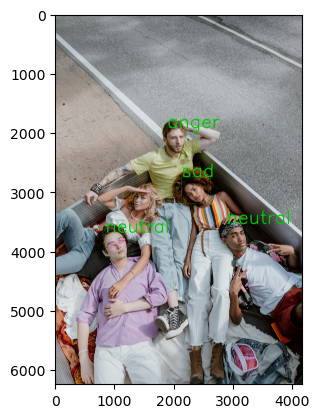

In [7]:
image = cv2.imread("data/ps.jpg")

input_image = preprocess(image, input_layer_face)
results = compiled_model_face([input_image])[output_layer_face]

confidence_threshold = .95
face_boxes, scores = find_faceboxes(image, results, confidence_threshold)
show_image = draw_faceboxes(image, face_boxes, scores)
draw_emotions(face_boxes, image, show_image)

plt.imshow(cv2.cvtColor(show_image, cv2.COLOR_BGR2RGB))

[0.28 0.03 0.05 0.   0.64] 4 anger
[0.55 0.32 0.08 0.   0.04] 0 neutral
[0.32 0.17 0.32 0.12 0.07] 2 sad
[0.65 0.02 0.12 0.01 0.2 ] 0 neutral


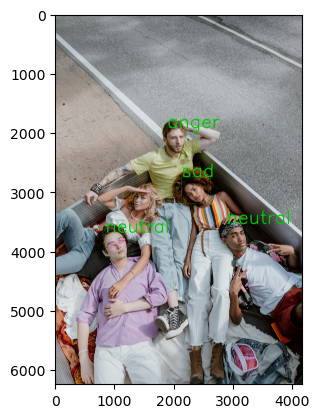

In [8]:
    EMOTION_NAMES = ['neutral', 'happy', 'sad', 'surpeise', 'anger']
    for i in range(len(face_boxes)):

        xmin, ymin, xmax, ymax = face_boxes[i]
        face = image[ymin : ymax, xmin : xmax]
        plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))

        input_image = preprocess(face, input_layer_emo)
        results_emo = compiled_model_emo([input_image])[output_layer_emo]

        results_emo = results_emo.squeeze()
        index = np.argmax(results_emo)

        text = EMOTION_NAMES[index]
        cv2.putText(show_image, text, (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 10, (0, 200, 0), 2)

        print(np.round(results_emo, 2), index, text)
        plt.imshow(cv2.cvtColor(show_image, cv2.COLOR_BGR2RGB))